In [1]:
pip install opencv-python-headless --upgrade


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Custom Affine Transformation Matrix:
[[-1.00000000e+00  1.33226763e-15  5.42000000e+02]
 [ 3.55382390e-13 -1.00000000e+00  5.41000000e+02]]
OpenCV Affine Transformation Matrix:
[[ -1.   0. 542.]
 [  0.  -1. 541.]]
MSE between Custom and OpenCV Affine Transformation Matrices: 6.339355608920554e-24


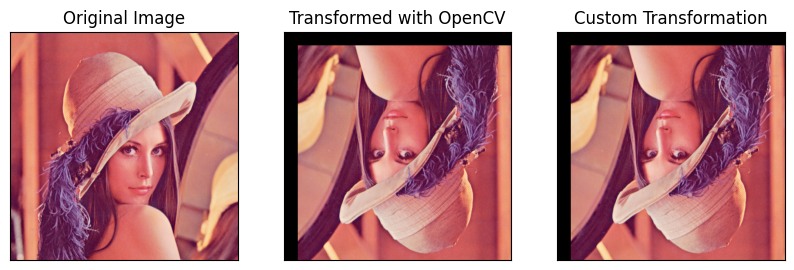

In [17]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# User prompt to select the image
image_selection = int(input("Choose an image (1-Lena, 2-Water, 3-Computer, 4-Mario, 5-Mountain): "))

# Mapping selection to corresponding file paths
image_data = {
    1: ('lena.csv', 'lena.png'),
    2: ('water.csv', 'water.jpg'),
    3: ('computer.csv', 'computer.png'),
    4: ('mario.csv', 'mario.jpg'),
    5: ('mountain.csv', 'mountain.jpg')
}

# Load image and CSV based on user selection
csv_file_path, image_file_path = image_data.get(image_selection, (None, None))
if csv_file_path is None or image_file_path is None:
    raise ValueError("Invalid image number selected.")

loaded_image = cv2.imread(image_file_path)
if loaded_image is None:
    raise FileNotFoundError(f"Image file not found: {image_file_path}")

point_data = pd.read_csv(csv_file_path)
if point_data.shape[0] <= 3:
    raise Exception("Data file contains fewer than 3 points, please check your data source.")
point_array = np.array(point_data, dtype=int)
source_points = point_array[:, :2]
destination_points = point_array[:, 2:]

# Automatically limit the point arrays to a maximum of 3 points
max_points = min(3, len(source_points))
source_points = source_points[:max_points]
destination_points = destination_points[:max_points]

def compute_affine_transform(src_points, dst_points):
    point_len = len(src_points)
    matrix_A = np.zeros((2 * point_len, 6))
    vector_B = np.zeros((2 * point_len))
    src_points = np.array(src_points)
    dst_points = np.array(dst_points)

    # Populate the transformation matrix A
    matrix_A[::2, 0:3] = np.hstack([src_points, np.ones((point_len, 1))])
    matrix_A[1::2, 3:6] = np.hstack([src_points, np.ones((point_len, 1))])

    # Populate the vector B with destination points
    vector_B[::2] = dst_points[:, 0]
    vector_B[1::2] = dst_points[:, 1]

    # Solving the linear system
    solved_affine_matrix, residuals, rank, singular_vals = np.linalg.lstsq(matrix_A, vector_B, rcond=None)
    return solved_affine_matrix.reshape(2, 3)

# Compute affine transformation with custom function
custom_affine_matrix = compute_affine_transform(source_points, destination_points)

# Use OpenCV to compute affine transformation
opencv_affine_matrix, transformation_status = cv2.estimateAffine2D(np.float32(source_points), np.float32(destination_points))

# Calculate MSE between the transformation matrices
def matrix_mse(matrix1, matrix2):
    return np.mean((matrix1 - matrix2) ** 2)

mse_matrix = matrix_mse(custom_affine_matrix, opencv_affine_matrix)

print("Custom Affine Transformation Matrix:")
print(custom_affine_matrix)
print("OpenCV Affine Transformation Matrix:")
print(opencv_affine_matrix)
print(f"MSE between Custom and OpenCV Affine Transformation Matrices: {mse_matrix}")

# Image dimensions
image_height, image_width = loaded_image.shape[:2]

# Applying transformations to the image
transformed_image_opencv = cv2.warpAffine(loaded_image, opencv_affine_matrix, (image_width, image_height))
transformed_image_custom = cv2.warpAffine(loaded_image, custom_affine_matrix, (image_width, image_height))

# Function to display images using Matplotlib
def display_images(image_list, title_list):
    plt.figure(figsize=(10, 5))
    for i, image in enumerate(image_list):
        plt.subplot(1, len(image_list), i + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(title_list[i])
        plt.xticks([]), plt.yticks([])
    plt.show()

# Display the images
display_images(
    [loaded_image, transformed_image_opencv, transformed_image_custom],
    ['Original Image', 'Transformed with OpenCV', 'Custom Transformation']
)
